# Multi-Seed Late Fusion with Weighted Fusion (Post Features)

This notebook runs late fusion across multiple random seeds with focus on POST-submit physiological features.

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

## 1. Load and Extract Features (Same as late_fusion_model.ipynb)

In [2]:
import re

preprocessing_dir = Path('../data/results/preprocessing')
preprocessing_files = sorted(preprocessing_dir.glob('preprocessing_*.json'))
raw_dir = Path('../data/json')
baseline_method = 't3_stable_pre_decision'

print(f"Found {len(preprocessing_files)} preprocessing files")
print(f"Baseline correction method: {baseline_method}")

Found 10 preprocessing files
Baseline correction method: t3_stable_pre_decision


In [3]:
# Extract all features (same as late_fusion_model.ipynb)
all_physiology_features = []
all_behavior_features = []
all_outcomes = []
all_subject_ids = []
all_trial_ids = []

for preprocessed_file in preprocessing_files:
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    print(f"\nProcessing subject: {subject_id}")
    
    matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
    pattern = subject_id.replace("_", ".*")
    match = next((f for f in matches if re.search(pattern, f.name)), None)
    if not match:
        print("No matching file found.")
        continue
    
    with open(match, 'r') as f:
        raw_data = json.load(f)
    
    subject_trial_count = 0
    
    for trial_id, trial_data in preprocessed['trial_data'].items():
        method_data = trial_data['methods'][baseline_method]
        
        if method_data['success'] != True:
            continue
        
        raw_trial = raw_data['trials'][int(trial_id)-1]
        
        if not raw_trial['gamble details']['submitted']:
            continue
        
        # Extract pupil data
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])

        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]

        if len(pupil_avg_clean) < 20:
            continue

        # POST-SUBMIT DATA ONLY (0 to 2 seconds after submit)
        post_submit_mask = (time_clean > 0) & (time_clean <= 2.0)
        pupil_post = pupil_avg_clean[post_submit_mask]
        pupil_L_post = pupil_L_clean[post_submit_mask]
        pupil_R_post = pupil_R_clean[post_submit_mask]
        time_post = time_clean[post_submit_mask]

        if len(pupil_post) < 5:
            continue

        # Calculate derivatives
        pupil_velocity_post = np.diff(pupil_post) if len(pupil_post) > 1 else np.array([0])
        pupil_acceleration_post = np.diff(pupil_velocity_post) if len(pupil_velocity_post) > 1 else np.array([0])
        dilation_mask_post = pupil_velocity_post > 0 if len(pupil_velocity_post) > 0 else np.array([False])

        # PHYSIOLOGY FEATURES (POST-SUBMIT ONLY)
        physiology_features = {
            # Central tendency
            'pupil_mean_post': np.mean(pupil_post),
            'pupil_std_post': np.std(pupil_post),
            
            # Temporal dynamics
            'pupil_slope_post': np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0,
            'time_to_peak_post': time_post[np.argmax(pupil_post)] - time_post[0] if len(time_post) > 0 else 0,
            
            # Variability
            'pupil_cv_post': np.std(pupil_post) / np.abs(np.mean(pupil_post)) if (len(pupil_post) > 0 and np.mean(pupil_post) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_post': np.mean(np.abs(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_dilation_rate_post': np.max(pupil_velocity_post) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_constriction_rate_post': np.abs(np.min(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            
            # Acceleration
            'pupil_acceleration_std_post': np.std(pupil_acceleration_post) if len(pupil_acceleration_post) > 1 else 0,
            
            # Temporal patterns
            'pct_time_dilating_post': np.mean(dilation_mask_post) if len(dilation_mask_post) > 0 else 0,
            'num_dilation_peaks_post': np.sum(np.diff(np.sign(pupil_velocity_post)) > 0) if len(pupil_velocity_post) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_post': np.nanmean(np.abs(pupil_L_post - pupil_R_post)) if len(pupil_L_post) > 0 else 0,
            'eye_asymmetry_std_post': np.nanstd(pupil_L_post - pupil_R_post) if len(pupil_L_post) > 1 else 0,
        }
        
        # BEHAVIOR FEATURES
        gamble_params = raw_trial['gamble details']['gamble parameters']
        lct = raw_trial['lct']
        
        show_screen_time = None
        submit_time = None
        click_time = None
        
        for event in lct:
            if 'show screen' in event['event']:
                show_screen_time = event['time']
            elif 'gamble clicked' in event['event']:
                click_time = event['time']
            elif 'submit' in event['event']:
                submit_time = event['time']
        
        if show_screen_time is None or submit_time is None:
            continue
        
        reaction_time = (click_time - show_screen_time) / 1000 if click_time else np.nan
        decision_time = (submit_time - show_screen_time) / 1000

        invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                    gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
        keep_ev = gamble_params['keep amount']
        ev_difference = invest_ev - keep_ev

        invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                        (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
        
        final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
        chose_invest = 1 if final_choice == 'INVEST' else 0
        
        behavior_features = {
            'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
            'decision_time': decision_time,
            'ev_difference': ev_difference,
            'invest_variance': invest_variance,
            'ambiguity': gamble_params['ambiguity'],
            'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
            'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
        }
                
        outcome = chose_invest
        
        all_physiology_features.append(physiology_features)
        all_behavior_features.append(behavior_features)
        all_outcomes.append(outcome)
        all_subject_ids.append(subject_id)
        all_trial_ids.append(f"{trial_id}_{subject_id}")
        
        subject_trial_count += 1
    
    print(f"  Extracted {subject_trial_count} valid trials")

physio_df = pd.DataFrame(all_physiology_features)
physio_df.insert(0, 'subject_id', all_subject_ids)
physio_df.insert(1, 'trial_id', all_trial_ids)
physio_df['outcome'] = all_outcomes

behavior_df = pd.DataFrame(all_behavior_features)
behavior_df.insert(0, 'subject_id', all_subject_ids)
behavior_df.insert(1, 'trial_id', all_trial_ids)
behavior_df['outcome'] = all_outcomes

print(f"\n{'='*80}")
print(f"Physiology (POST-SUBMIT): {len(physio_df)} trials, {len([c for c in physio_df.columns if c not in ['subject_id', 'trial_id', 'outcome']])} features")
print(f"Behavior: {len(behavior_df)} trials, {len([c for c in behavior_df.columns if c not in ['subject_id', 'trial_id', 'outcome']])} features")


Processing subject: 0927_0930_U9TEJGM
  Extracted 99 valid trials

Processing subject: 0928_1600_539136F
  Extracted 110 valid trials

Processing subject: 0928_1600_9M4VCHG
  Extracted 117 valid trials

Processing subject: 0928_1600_U9TEJGM
  Extracted 93 valid trials

Processing subject: 0930_1700_539136F
  Extracted 95 valid trials

Processing subject: 0930_1700_9M4VCHG
  Extracted 112 valid trials

Processing subject: 0930_1700_U9TEJGM
  Extracted 123 valid trials

Processing subject: 1005_1600_539136F
  Extracted 121 valid trials

Processing subject: 1005_1600_9M4VCHG
  Extracted 123 valid trials

Processing subject: 1005_1600_U9TEJGM
  Extracted 51 valid trials

Physiology (POST-SUBMIT): 1044 trials, 13 features
Behavior: 1044 trials, 7 features


## 2. Load Gaze Data

In [4]:
def extract_gaze_features_from_trial(eye_data):
    """Extract gaze features from raw eye tracking data."""
    if not eye_data or len(eye_data) == 0:
        return None
    
    timestamps = np.array([s['time'] for s in eye_data])
    
    gaze_x_L = np.array([s.get('gazeL_X', np.nan) for s in eye_data])
    gaze_y_L = np.array([s.get('gazeL_Y', np.nan) for s in eye_data])
    gaze_x_R = np.array([s.get('gazeR_X', np.nan) for s in eye_data])
    gaze_y_R = np.array([s.get('gazeR_Y', np.nan) for s in eye_data])
    
    gaze_x = np.nanmean([gaze_x_L, gaze_x_R], axis=0)
    gaze_y = np.nanmean([gaze_y_L, gaze_y_R], axis=0)
    
    screen_x_L = np.array([s.get('pupilLSensorPosL_X', np.nan) for s in eye_data])
    screen_y_L = np.array([s.get('pupilLSensorPosL_Y', np.nan) for s in eye_data])
    screen_x_R = np.array([s.get('pupilLSensorPosR_X', np.nan) for s in eye_data])
    screen_y_R = np.array([s.get('pupilLSensorPosR_Y', np.nan) for s in eye_data])
    
    screen_x = np.nanmean([screen_x_L, screen_x_R], axis=0)
    screen_y = np.nanmean([screen_y_L, screen_y_R], axis=0)
    
    valid_L = np.array([s.get('validL', 0) for s in eye_data])
    valid_R = np.array([s.get('validR', 0) for s in eye_data])
    
    features = {}
    features['gaze_valid_pct'] = np.mean((valid_L > 0) & (valid_R > 0))
    
    valid_mask = (valid_L > 0) & (valid_R > 0)
    if valid_mask.sum() < 5:
        return None
    
    gaze_x_valid = gaze_x[valid_mask]
    gaze_y_valid = gaze_y[valid_mask]
    screen_x_valid = screen_x[valid_mask]
    screen_y_valid = screen_y[valid_mask]
    timestamps_valid = timestamps[valid_mask]
    
    features['gaze_x_mean'] = np.nanmean(gaze_x_valid)
    features['gaze_x_std'] = np.nanstd(gaze_x_valid)
    features['gaze_y_mean'] = np.nanmean(gaze_y_valid)
    features['gaze_y_std'] = np.nanstd(gaze_y_valid)
    features['screen_x_mean'] = np.nanmean(screen_x_valid)
    features['screen_x_std'] = np.nanstd(screen_x_valid)
    features['screen_y_mean'] = np.nanmean(screen_y_valid)
    features['screen_y_std'] = np.nanstd(screen_y_valid)
    
    dt = np.diff(timestamps_valid)
    dt[dt == 0] = 1e-6
    dx = np.diff(screen_x_valid)
    dy = np.diff(screen_y_valid)
    
    velocity = np.sqrt(dx**2 + dy**2) / dt
    features['gaze_velocity_mean'] = np.nanmean(velocity)
    features['gaze_velocity_std'] = np.nanstd(velocity)
    features['gaze_velocity_max'] = np.nanmax(velocity)
    
    acceleration = np.diff(velocity) / dt[:-1]
    features['gaze_acceleration_mean'] = np.nanmean(np.abs(acceleration))
    features['gaze_acceleration_std'] = np.nanstd(acceleration)
    
    fixation_mask = velocity < 30
    saccade_mask = velocity > 100
    features['fixation_ratio'] = np.mean(fixation_mask)
    features['saccade_ratio'] = np.mean(saccade_mask)
    features['saccade_count'] = np.sum(np.diff(saccade_mask.astype(int)) == 1)
    
    features['gaze_dispersion_x'] = np.nanmax(screen_x_valid) - np.nanmin(screen_x_valid)
    features['gaze_dispersion_y'] = np.nanmax(screen_y_valid) - np.nanmin(screen_y_valid)
    features['gaze_path_length'] = np.sum(np.sqrt(dx**2 + dy**2))
    
    return features

def map_subject_filename(json_filename):
    import re
    match = re.search(r'(\d{4})_(\d{4})_LCT_DESKTOP-([A-Z0-9]+)', json_filename)
    if match:
        date1, date2, desktop_id = match.groups()
        return f"{date1}_{date2}_{desktop_id}"
    return None

def extract_gaze_data(raw_json_files):
    all_gaze_data = []
    
    for file_path in raw_json_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        subject_id = map_subject_filename(file_path.name)
        if not subject_id:
            continue
        
        trials = data.get('trials', [])
        
        for trial_idx, trial in enumerate(trials):
            eye_data = trial.get('eye', [])
            if not eye_data:
                continue
            
            gamble_details = trial.get('gamble details', {})
            trial_id = str(gamble_details.get('trial', trial_idx))
            
            gaze_features = extract_gaze_features_from_trial(eye_data)
            if gaze_features is None:
                continue
            
            gaze_features['subject_id'] = subject_id
            gaze_features['trial_id'] = f"{trial_id}_{subject_id}"
            all_gaze_data.append(gaze_features)
    
    gaze_df = pd.DataFrame(all_gaze_data)
    print(f"Gaze: {len(gaze_df)} trials, {len([c for c in gaze_df.columns if c not in ['subject_id', 'trial_id']])} features")
    return gaze_df

raw_json_dir = Path('../data/json')
raw_json_files = sorted(raw_json_dir.glob('*.json'))
gaze_df = extract_gaze_data(raw_json_files)

Gaze: 1383 trials, 20 features


## 3. Merge All Modalities

In [5]:
merged_df = physio_df.merge(
    behavior_df.drop(columns=['outcome']),
    on=['subject_id', 'trial_id'],
    how='inner'
)

merged_df = merged_df.merge(
    gaze_df,
    on=['subject_id', 'trial_id'],
    how='inner'
)

print(f"Merged data: {len(merged_df)} trials")
print(f"Outcome distribution:\n{merged_df['outcome'].value_counts()}")

Merged data: 1044 trials
Outcome distribution:
outcome
1    688
0    356
Name: count, dtype: int64


## 4. Prepare Feature Sets

In [6]:
# POST features only for physiology
physio_cols = [c for c in merged_df.columns if c.endswith('_post')]

behavior_cols = ['reaction_time', 'decision_time', 'ev_difference', 
                 'invest_variance', 'ambiguity', 'condition_social', 'risk_premium']

gaze_cols = [c for c in merged_df.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology (POST only): {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")

X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"\nShapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")

Physiology (POST only): 13 features
Behavior: 7 features
Gaze: 20 features

Shapes: X_physio=(1044, 13), X_behavior=(1044, 7), X_gaze=(1044, 20)


## 5. Multi-Seed Weighted Late Fusion

In [7]:
def weighted_late_fusion(X_modalities, y, subjects, modality_names, random_seed):
    """
    Weighted late fusion with specific random seed.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=random_seed)
                   for _ in X_modalities]
    
    accs, f1s, all_weights = [], [], []
    preds_all, y_true_all = [], []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        # Train base models and get probabilities
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Weighted fusion via logistic regression
        meta = LogisticRegression(random_state=random_seed, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accs.append(acc)
        f1s.append(f1)
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'seed': random_seed,
        'accuracy': np.mean(accs),
        'accuracy_std': np.std(accs),
        'f1_score': np.mean(f1s),
        'f1_std': np.std(f1s),
        'weights': norm_weights,
        'modality_names': modality_names,
    }

In [8]:
# Run multiple seeds
SEEDS = [42, 123, 456, 789, 1024, 2048, 3141, 5678, 8888, 9999]
X_modalities = [X_physio, X_behavior, X_gaze]
modality_names = ['Physiology (POST)', 'Behavior', 'Gaze']

results = []
for seed in SEEDS:
    print(f"\nRunning seed {seed}...")
    result = weighted_late_fusion(X_modalities, y, subjects, modality_names, seed)
    results.append(result)
    print(f"  Accuracy: {result['accuracy']:.3f} ± {result['accuracy_std']:.3f}")
    print(f"  F1-Score: {result['f1_score']:.3f} ± {result['f1_std']:.3f}")
    print(f"  Weights: {result['weights']}")


Running seed 42...
  Accuracy: 0.709 ± 0.175
  F1-Score: 0.697 ± 0.208
  Weights: [0.11436289 0.30290102 0.58273609]

Running seed 123...
  Accuracy: 0.702 ± 0.175
  F1-Score: 0.690 ± 0.207
  Weights: [0.10237286 0.28865683 0.60897031]

Running seed 456...
  Accuracy: 0.713 ± 0.174
  F1-Score: 0.698 ± 0.205
  Weights: [0.09550168 0.28155346 0.62294486]

Running seed 789...
  Accuracy: 0.708 ± 0.188
  F1-Score: 0.691 ± 0.223
  Weights: [0.10705486 0.28509921 0.60784593]

Running seed 1024...
  Accuracy: 0.710 ± 0.184
  F1-Score: 0.695 ± 0.221
  Weights: [0.09839671 0.28994439 0.6116589 ]

Running seed 2048...
  Accuracy: 0.714 ± 0.179
  F1-Score: 0.699 ± 0.211
  Weights: [0.09346917 0.2695837  0.63694714]

Running seed 3141...
  Accuracy: 0.710 ± 0.172
  F1-Score: 0.696 ± 0.207
  Weights: [0.12367709 0.309274   0.56704891]

Running seed 5678...
  Accuracy: 0.712 ± 0.180
  F1-Score: 0.698 ± 0.210
  Weights: [0.09804744 0.27444932 0.62750324]

Running seed 8888...
  Accuracy: 0.710 ± 0.1

## 6. Aggregate Results Across Seeds

In [9]:
# Create summary DataFrame
summary_df = pd.DataFrame([
    {
        'Seed': r['seed'],
        'Accuracy': r['accuracy'],
        'Accuracy_Std': r['accuracy_std'],
        'F1-Score': r['f1_score'],
        'F1_Std': r['f1_std'],
        'Physiology_Weight': r['weights'][0],
        'Behavior_Weight': r['weights'][1],
        'Gaze_Weight': r['weights'][2]
    }
    for r in results
])

print("\n" + "="*80)
print("MULTI-SEED RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("AGGREGATE STATISTICS")
print("="*80)
print(f"Mean Accuracy: {summary_df['Accuracy'].mean():.3f} ± {summary_df['Accuracy'].std():.3f}")
print(f"Mean F1-Score: {summary_df['F1-Score'].mean():.3f} ± {summary_df['F1-Score'].std():.3f}")
print(f"\nMean Modality Weights:")
print(f"  Physiology (POST): {summary_df['Physiology_Weight'].mean():.3f} ± {summary_df['Physiology_Weight'].std():.3f}")
print(f"  Behavior:          {summary_df['Behavior_Weight'].mean():.3f} ± {summary_df['Behavior_Weight'].std():.3f}")
print(f"  Gaze:              {summary_df['Gaze_Weight'].mean():.3f} ± {summary_df['Gaze_Weight'].std():.3f}")


MULTI-SEED RESULTS SUMMARY
 Seed  Accuracy  Accuracy_Std  F1-Score   F1_Std  Physiology_Weight  Behavior_Weight  Gaze_Weight
   42  0.709346      0.174784  0.696571 0.208388           0.114363         0.302901     0.582736
  123  0.701895      0.174995  0.690260 0.206983           0.102373         0.288657     0.608970
  456  0.712691      0.174474  0.697913 0.204651           0.095502         0.281553     0.622945
  789  0.708106      0.188072  0.690768 0.222525           0.107055         0.285099     0.607846
 1024  0.710265      0.184138  0.695424 0.221230           0.098397         0.289944     0.611659
 2048  0.713571      0.178613  0.699293 0.210853           0.093469         0.269584     0.636947
 3141  0.710445      0.171807  0.696162 0.207283           0.123677         0.309274     0.567049
 5678  0.711888      0.180000  0.697737 0.209685           0.098047         0.274449     0.627503
 8888  0.709502      0.181036  0.694608 0.213711           0.101847         0.296601     0

## 7. Visualizations

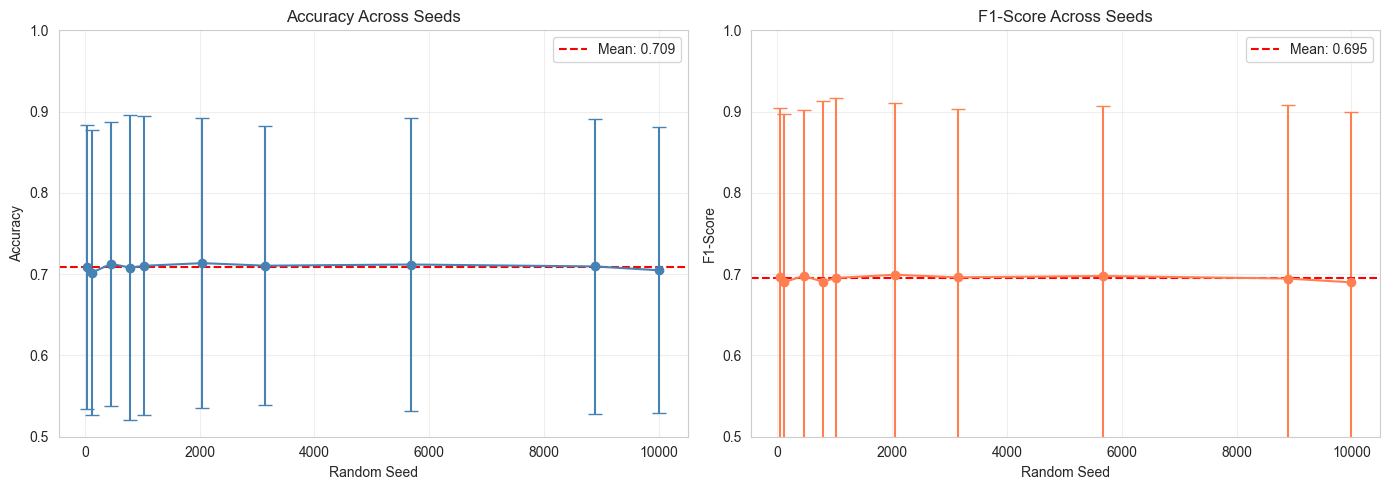

In [10]:
# Performance across seeds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.errorbar(summary_df['Seed'], summary_df['Accuracy'], 
            yerr=summary_df['Accuracy_Std'], fmt='o-', capsize=5, color='steelblue')
ax.axhline(summary_df['Accuracy'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['Accuracy'].mean():.3f}")
ax.set_xlabel('Random Seed')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Across Seeds')
ax.set_ylim([0.5, 1.0])
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.errorbar(summary_df['Seed'], summary_df['F1-Score'], 
            yerr=summary_df['F1_Std'], fmt='o-', capsize=5, color='coral')
ax.axhline(summary_df['F1-Score'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['F1-Score'].mean():.3f}")
ax.set_xlabel('Random Seed')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Across Seeds')
ax.set_ylim([0.5, 1.0])
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

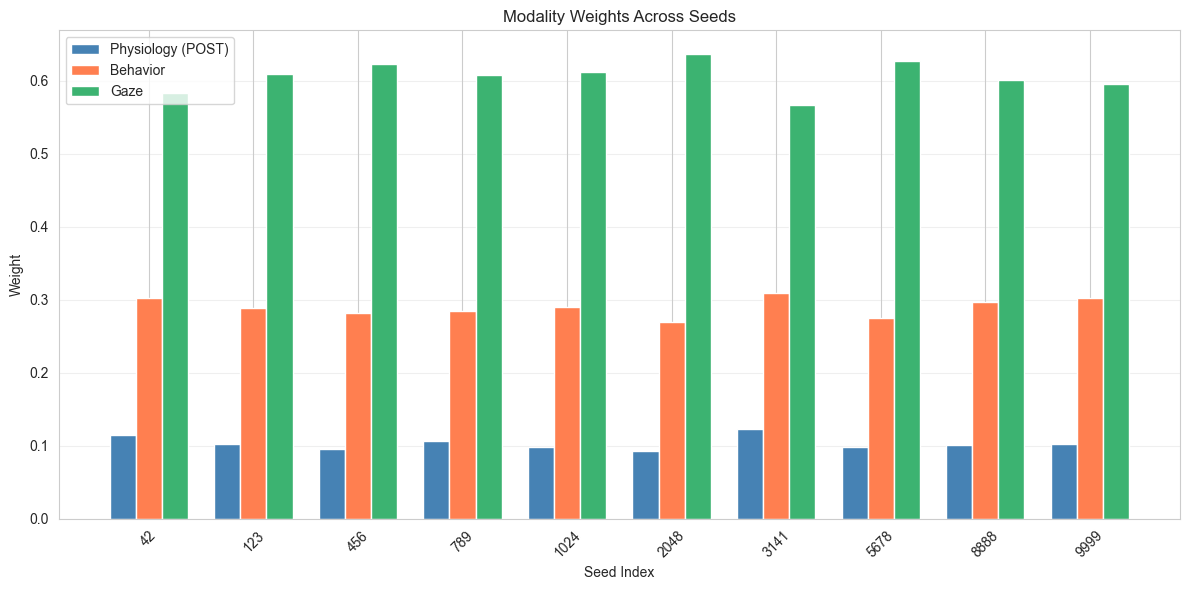

In [11]:
# Modality weights across seeds
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(SEEDS))
width = 0.25

ax.bar(x - width, summary_df['Physiology_Weight'], width, label='Physiology (POST)', color='steelblue')
ax.bar(x, summary_df['Behavior_Weight'], width, label='Behavior', color='coral')
ax.bar(x + width, summary_df['Gaze_Weight'], width, label='Gaze', color='mediumseagreen')

ax.set_xlabel('Seed Index')
ax.set_ylabel('Weight')
ax.set_title('Modality Weights Across Seeds')
ax.set_xticks(x)
ax.set_xticklabels(SEEDS, rotation=45)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

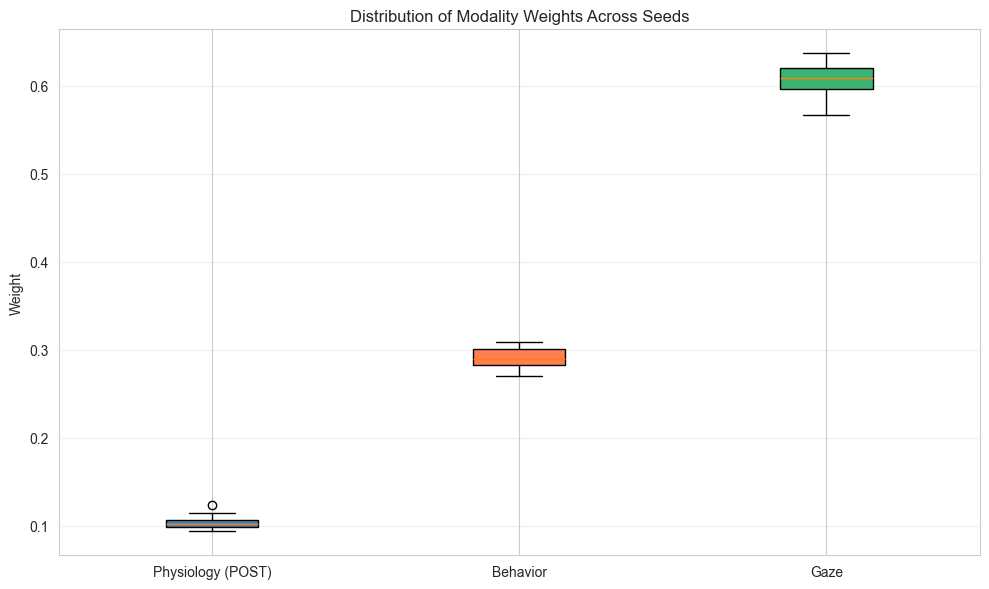

In [12]:
# Box plots of weights
fig, ax = plt.subplots(figsize=(10, 6))

weight_data = [
    summary_df['Physiology_Weight'].values,
    summary_df['Behavior_Weight'].values,
    summary_df['Gaze_Weight'].values
]

bp = ax.boxplot(weight_data, labels=modality_names, patch_artist=True)
colors = ['steelblue', 'coral', 'mediumseagreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Weight')
ax.set_title('Distribution of Modality Weights Across Seeds')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()